In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/입찰/LSTM

/content/drive/MyDrive/Colab Notebooks/입찰/LSTM


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.optimizers import Adam, RMSprop

In [ ]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test

sc1 = MinMaxScaler(feature_range=(0,1))
scaled_train = sc1.fit_transform(train_raw) # scaled train
scaled_test = sc1.fit_transform(test_raw) # scaled test

(2443, 1)
(272, 1)


In [ ]:
def datamake(data):
  ndata = []
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    temp = sum / 2
    ndata.append(temp)
  ndata.append(data[-1])
  ndata = np.array(ndata) # train_added
  return ndata

In [ ]:
train_added_scaled = datamake(scaled_train)
test_added_scaled = datamake(scaled_test)
print(train_added_scaled.shape)
print(test_added_scaled.shape)

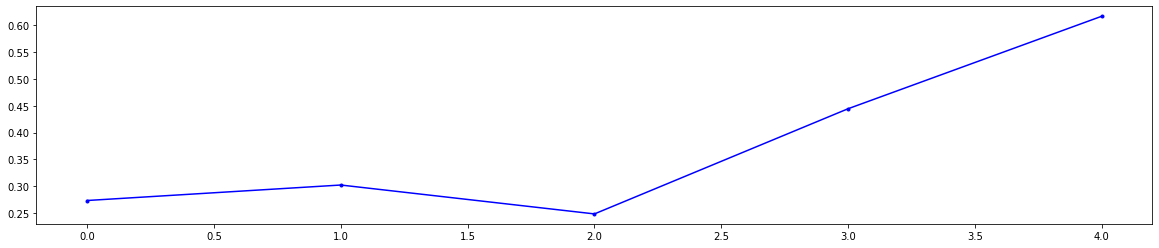

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(scaled_train[-5:,:], '.-',color = 'blue', label = 'GroundTruth')

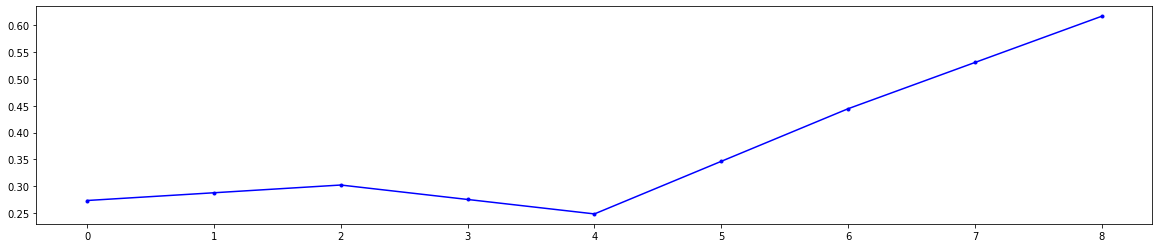

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(train_added_scaled[-9:,:], '.-',color = 'blue', label = 'GroundTruth')

In [ ]:
seq_length = 7 ############## 6, 7

In [ ]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [ ]:
X_train, Y_train = make_data(train_added_scaled) # train_added_scaled
X_test, Y_test = make_data(test_added_scaled) # test_added_scaled

In [ ]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

concat = concatenate([x, y])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
output = Dense(1)(output)
model = Model(inputs = inputs, outputs = output)

#model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, Y_train, epochs = 70, batch_size = 10, validation_split=0.1)

Epoch 1/100
439/439 [==============================] - 10s 11ms/step - loss: 0.0280 - val_loss: 0.0223
Epoch 2/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0247 - val_loss: 0.0213
Epoch 3/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0203 - val_loss: 0.0104
Epoch 4/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0119 - val_loss: 0.0071
Epoch 5/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 6/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 7/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 8/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0087 - val_loss: 0.0064
Epoch 9/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 10/100
439/439 [==============================] - 4s 8ms/step - loss: 0.0083 - val_

KeyboardInterrupt: ignored

In [ ]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

mean_train_error = np.average(np.abs(train_added[seq_length:,:] - predicted_X_train))

print("평균 training error:", mean_train_error)

평균 training error: 0.16316576426251195


In [ ]:
predicted_X_test = model.predict(X_test)
predicted_X_test = sc1.inverse_transform(predicted_X_test)

mean_train_error = np.average(np.abs(test_added[seq_length:,:] - predicted_X_test))

print("평균 test error:", mean_train_error)

평균 test error: 0.10782642970825687


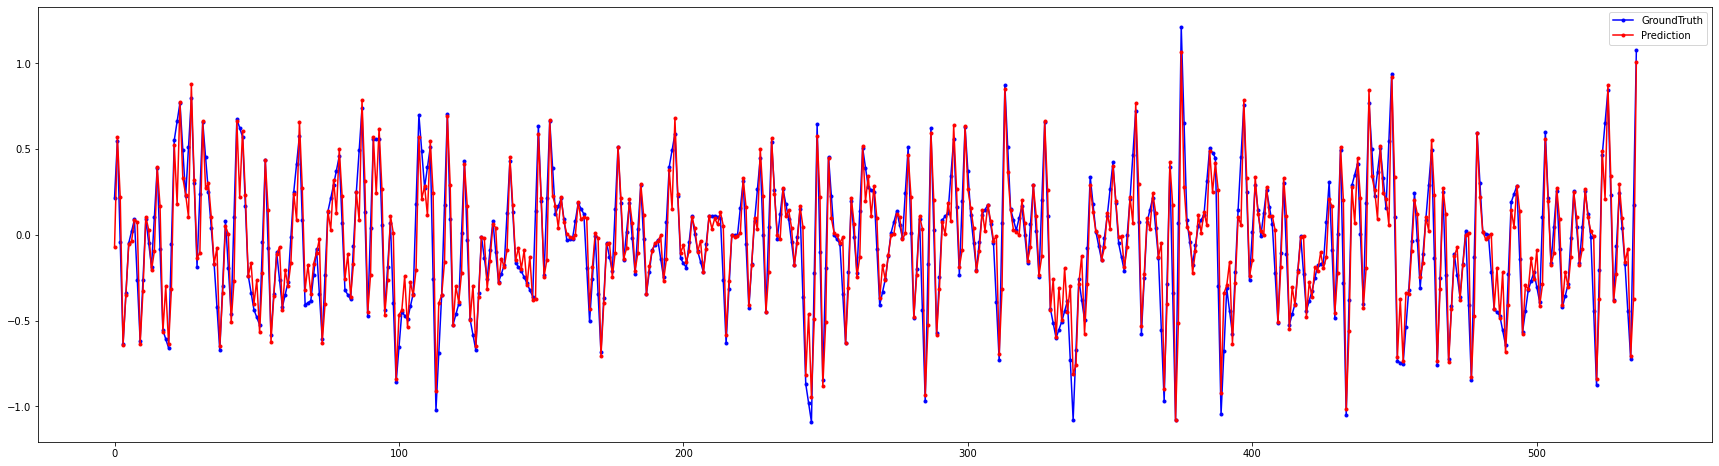

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test_added[seq_length:,:], '.-',color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_test, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM1_test')

In [ ]:
pred1 = model.predict(test_added_scaled[-seq_length:].reshape(1,seq_length,1)) # scaled_pred 1
dummy = test_added_scaled[-seq_length:] # origin input data
dummy = np.append(dummy, pred1, axis=0) # add scaled_pred1

pred2 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## first pred
dummy = np.append(dummy, pred2, axis=0) # add scaled_pred2

pred3 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1))
dummy = np.append(dummy, pred3, axis=0) # add scaled_pred3

pred4 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## second pred
dummy = np.append(dummy, pred4, axis=0) # add scaled_pred4

pred5 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1))
dummy = np.append(dummy, pred5, axis=0) # add scaled_pred5

pred6 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## third pred
dummy = np.append(dummy, pred6, axis=0) # add scaled_pred6

result1 = sc1.inverse_transform(pred2)
result2 = sc1.inverse_transform(pred4)
result3 = sc1.inverse_transform(pred6)
print('result1 : ', result1)
print('result2 : ', result2)
print('result3 : ', result3)

result1 :  [[-0.33691275]]
result2 :  [[-0.03180146]]
result3 :  [[-0.04735224]]


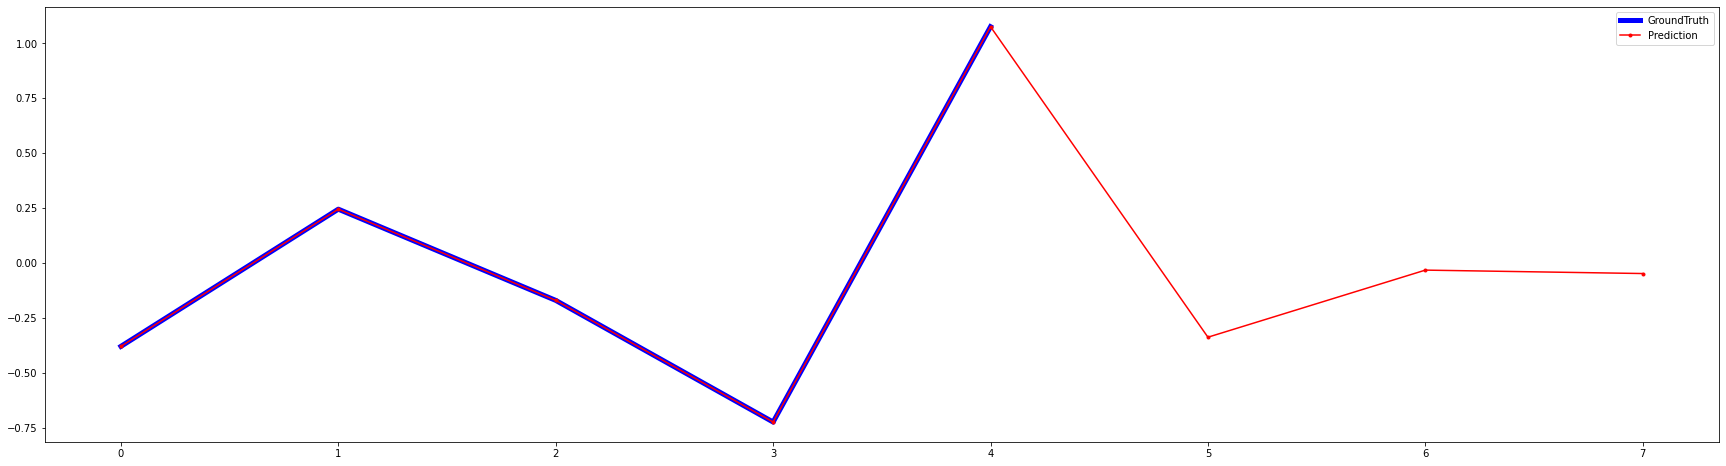

In [ ]:
dum = test_raw[-5:]
dum = np.append(dum, result1)
dum = np.append(dum, result2)
dum = np.append(dum, result3)
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test_raw[-5:], '.-',color = 'blue', label = 'GroundTruth', linewidth=5.0)
plt.plot(dum, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM1_predict.png')